In [1]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os 
import IPython

# Set model hyperparameters and feature hyperparameters

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
sr = 8000
num_samples = 12000
nfft=1024
nmels=40
f_min=0
f_max=None

batch_size = 64
num_epochs = 150
loss = torch.nn.CrossEntropyLoss()

cuda


# Choose a feature to transform the data to and visualize

In [2]:
all_files = os.listdir("../../datasets/audioMinst")
all_files[:5] 

['4_theo_16.wav',
 '3_yweweler_18.wav',
 '3_yweweler_10.wav',
 '3_nicolas_45.wav',
 '6_yweweler_43.wav']

In [6]:
og_files = []
trim_files = []
sr = 8000
for file in all_files:
    og_file, rate = torchaudio.load("../../datasets/audioMinst/" + file, normalize=True)
    og_files.append(og_file)
    sr = rate
    trim_file = torch.cat((torch.zeros(1, 2000), og_file[:, 2000:]), dim=1)
    trim_files.append(trim_file)
    filename = file.split('.')[0]
    torchaudio.save('../../datasets/trimming/' + filename + '_trim.wav', trim_file, 8000)

In [72]:
IPython.display.Audio(og_files[1],rate = sr)    

In [73]:
IPython.display.Audio(trim_files[1],rate = sr)    

Downloading: "https://dl.fbaipublicfiles.com/encodec/v0/encodec_24khz-d7cc33bc.th" to /home/aneri/.cache/torch/hub/checkpoints/encodec_24khz-d7cc33bc.th
100.0%


shape of feature: torch.Size([1, 10, 24])


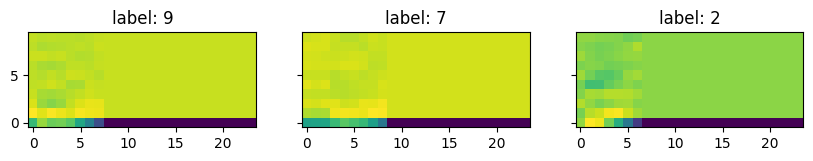

In [3]:
melSpec = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=nfft, n_mels=nmels, f_min=f_min, f_max=f_max)
mfcc = torchaudio.transforms.MFCC(sample_rate=sr, n_mfcc=10, melkwargs={'n_fft':nfft, 'n_mels':nmels})
codec = CodecTransform(sample_rate=sr, bandwidth=6.0)

dataSet = SoundDataset('audioMinst', transformation=mfcc, target_sample_rate=sr, num_samples=num_samples)
train_data, val_data = torch.utils.data.random_split(dataSet, (2500, 500))
train_dl = DataLoader(train_data, batch_size=batch_size)
val_dl = DataLoader(val_data, batch_size=batch_size)
input_shape = None

fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)
for i in range(3):
    img, label = val_data[i]
    if i==0:
        print('shape of feature:', img.shape)
        input_shape = img.shape
    axs[i].imshow(img[0], origin='lower')
    axs[i].set_title(f'label: {label}')


# Initialize the Network

In [4]:
model = CNNNetwork(out_neurons=10, input_shape=input_shape, layers=[8, 16, 32, 64])
#model = LSTMNetwork(input_dim=8, lstm_layers=[32, 24], linear_layers=[16, 10])

model = model.to(device)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss = torch.nn.CrossEntropyLoss()

CNNNetwork(
  (conv_layer0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=384, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [5]:
def train_epoch(model, train_data_loader, val_data_loader, loss_fn, opt, device, metrics):

    model.train()
    losses = []
    accuracies = []
    for input, target in train_data_loader:
        input, target = input.float().to(device), target.to(device)

        # calculate loss
        prediction = model(input)
        loss = loss_fn(prediction, target)
        _, preds = torch.max(prediction.data, 1)
        accuracies.append((preds == target).float().mean())
        losses.append(loss.item())
        # backpropagate error and update weights
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    metrics['t_acc'].append(sum(accuracies)/len(accuracies))
    metrics['t_loss'].append(sum(losses)/sum(accuracies))
    
    model.eval()
    losses = []
    accuracies = []
    for input, target in val_data_loader:
        input, target = input.to(device), target.to(device)
        prediction = model(input)
        loss = loss_fn(prediction, target)
        _, preds = torch.max(prediction.data, 1)
        accuracies.append((preds == target).float().mean())
        losses.append(loss.item())
    
    metrics['v_acc'].append(sum(accuracies)/len(accuracies))
    metrics['v_loss'].append(sum(losses)/sum(accuracies))

          

In [6]:
metrics = {
    't_loss': [],
    'v_loss': [],
    't_acc': [],
    'v_acc': []
}
print('****** STARTING TRAINING ******')
for epoch in range(num_epochs):
    train_epoch(model, train_dl, val_dl, loss_fn=loss, opt=optimizer, device=device, metrics=metrics)
    print(f"Finished epoch: {epoch} Val loss: {metrics['v_loss'][-1]}")

print("Fininshed training")    
print('best validation accuracy', max(metrics['v_acc']).data)

plt.plot(metrics['t_loss'])
plt.plot(metrics['v_loss'])
plt.legend(['training', 'validation'])
plt.title('cross entropy loss')
plt.show()

plt.figure(1)
plt.plot(metrics['t_acc'])
plt.plot(metrics['v_acc'])
plt.legend(['training', 'validation'])
plt.title('accuracy')

****** STARTING TRAINING ******
torch.Size([64, 1, 10, 24])
torch.Size([64, 8, 6, 13])
torch.Size([64, 16, 4, 7])
torch.Size([64, 32, 3, 4])
torch.Size([64, 64, 2, 3])
Finished epoch: 0 Val loss: 22.79452896118164
Finished epoch: 1 Val loss: 15.1439790725708
Finished epoch: 2 Val loss: 13.809484481811523
Finished epoch: 3 Val loss: 11.21994686126709
Finished epoch: 4 Val loss: 9.394502639770508
Finished epoch: 5 Val loss: 6.7848405838012695
Finished epoch: 6 Val loss: 6.22121524810791
Finished epoch: 7 Val loss: 5.679296970367432
Finished epoch: 8 Val loss: 5.265852451324463
Finished epoch: 9 Val loss: 5.087989330291748
Finished epoch: 10 Val loss: 4.610058784484863
Finished epoch: 11 Val loss: 4.429529666900635
Finished epoch: 12 Val loss: 4.345503807067871
Finished epoch: 13 Val loss: 4.242002487182617
Finished epoch: 14 Val loss: 4.147792339324951
Finished epoch: 15 Val loss: 4.0593342781066895
Finished epoch: 16 Val loss: 3.9456779956817627
Finished epoch: 17 Val loss: 3.8110370635

KeyboardInterrupt: 

## Test the data on an unseen dataset, my voice

In [8]:
testDataSet = SoundDataset('dylanMnist', transformation=mfcc, target_sample_rate=sr, num_samples=num_samples)
testDL = DataLoader(testDataSet, batch_size=1)
correct = 0
model.eval()
for inp, target in testDL:
    inp, target = inp.to(device), target.to(device)
    prediction = model(inp)
    _, preds = torch.max(prediction.data, 1)
    if target[0] == preds[0]:
        correct += 1
    print(f'label was {target[0]}. Model Classified as {preds[0]}')
    
print(f'test accuracy: {correct/10}')

label was 1. Model Classified as 1
label was 0. Model Classified as 0
label was 6. Model Classified as 6
label was 8. Model Classified as 8
label was 7. Model Classified as 7
label was 3. Model Classified as 8
label was 5. Model Classified as 9
label was 4. Model Classified as 4
label was 2. Model Classified as 2
label was 9. Model Classified as 9
test accuracy: 0.8
